In [47]:
import os
import cv2
import s3fs
import glob
import zarr
import boto3
import fsspec
import pathlib
import dask.array
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rxr

import rasterio
from rasterio.crs import CRS
from rasterio.transform import Affine
from rasterio.plot import show, plotting_extent

import cartopy
import cartopy.crs as ccrs

import matplotlib
import matplotlib.pyplot as plt

from shapely.geometry import box, mapping, shape, Point, LineString, MultiPolygon, LinearRing, Polygon
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Delete this block once we are in GDAL >= 3.5
awsdir = pathlib.Path("~/.aws").expanduser()
awsdir.mkdir(exist_ok=True)
awscred = awsdir / "credentials"

session = boto3.session.Session()
credentials = session.get_credentials()
credentials = credentials.get_frozen_credentials()

#Credentials are refreshable, so accessing your access key / secret key
#separately can lead to a race condition. Use this to get an actual matched
#set. 

outstring = f"""
[default]
aws_access_key_id={credentials.access_key}
aws_secret_access_key={credentials.secret_key}
aws_session_token={credentials.token}
"""
with awscred.open(mode='w') as f:
    f.write(outstring)

# Read in AVIRIS data

In [3]:
# Connect to AWS S3 storage
s3 = s3fs.S3FileSystem(anon=False, client_kwargs=dict(region_name='us-west-2'))

In [4]:
bucket = 'dh-shift-curated'
key = 'aviris/20220228/'
s3_key = os.path.join(bucket, key)

In [5]:
# An example flight path from the date 20220228
item = 'ang20220228t190702'
s3_path = f's3://{s3_key}{item}_100-100-100.zarr'
store = s3fs.S3Map(root=s3_path, s3=s3, check=False)

In [6]:
# Read in Zarr dataset using xarray
ds = xr.open_zarr(store=store, decode_coords='all', consolidated=True)

In [7]:
# Check the coordinate reference system
ds.rio.crs

CRS.from_epsg(32610)

In [8]:
# Set dimensions and coordinates
ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y')
ds = ds.set_coords(('Easting', 'Northing'))

The Zarr dataset has dimensions `x`, `y`, and `wavelength`. The coordinates include the `Easting` and `Northing` coordinates. Data variables include `Elevation`, `Radiance`, and `Reflectance`.

In [9]:
ds

<xarray.Dataset>
Dimensions:      (x: 598, y: 16418, wavelength: 425)
Coordinates:
    Easting      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Northing     (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    band         (wavelength) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    fwhm         (wavelength) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    spatial_ref  int64 ...
  * wavelength   (wavelength) float64 377.1 382.1 387.1 ... 2.496e+03 2.501e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 594.5 595.5 596.5 597.5
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 1.642e+04 1.642e+04 1.642e+04
Data variables:
    Elevation    (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Radiance     (x, y, wavelength) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    Reflectance  (x, y, wavelength) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>

# Visualize RGB composite map

In [10]:
# Select single wavelength bands
Red = ds.sel(wavelength=670, method='nearest').Reflectance
Green = ds.sel(wavelength=550, method='nearest').Reflectance
Blue = ds.sel(wavelength=440, method='nearest').Reflectance

Plot individual band maps.

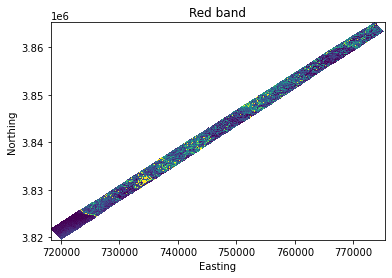

In [11]:
Red.plot.pcolormesh('Easting', 'Northing', robust=True, add_colorbar=False)
plt.title('Red band');

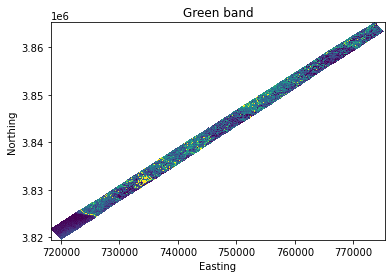

In [12]:
Green.plot.pcolormesh('Easting', 'Northing', robust=True, add_colorbar=False)
plt.title('Green band');

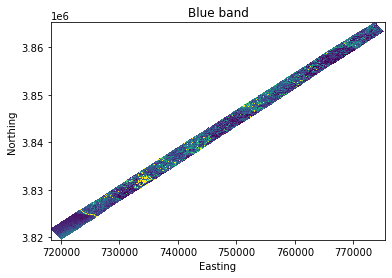

In [13]:
Blue.plot.pcolormesh('Easting', 'Northing', robust=True, add_colorbar=False)
plt.title('Blue band');

In [14]:
# Select an RGB composite 
RGB = ds.sel(wavelength=[670,550,440], method='nearest').Reflectance

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


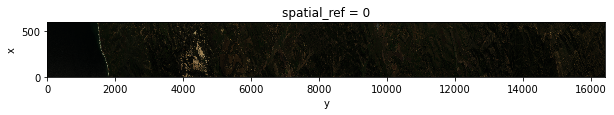

In [15]:
plt.figure(figsize=(10,1))
RGB.plot.imshow();

Need a functionality to plot RGB composite in spatially correct space (with Northing and Easting coordinates).

# Subset spatial region 

A common data operation is to subset a particular region using a shape vector. We first attempted to use available spatial tools, such as the `rasterio` package (Method 1 below). However, some custom code that implements shape masking is required to successfully subset a region (Method 2).

## Method 1: Using available spatial packages

This method attempts to define an affine transform for the dataset, create a shape using geopanda GeoDataFrame, and clip the region defined by the shape using `clip()` from rasterio. However, this function subsets the data based on the data dimensions `x` and `y` while we wish to work in Easting and Northing coordinates. 

In [16]:
# Simple box: top left and bottom right Easting and Northing coordinates
box_minx = 723500 
box_maxx = 726000 
box_miny = 3824000 
box_maxy = 3826000 

In [17]:
def affine_from_bounds(ds):
    m = len(ds.x)  # Number of columns
    n = len(ds.y)  # Number of rows
    
    ul = ds.isel(x=0, y=0)  # Upper left corner
    ur = ds.isel(x=-1, y=0) # Upper right corner
    ll = ds.isel(x=0, y=-1) # Lower left corner
    lr = ds.isel(x=-1, y=-1) # Lower right corner
    
    ul2 = (ul.Easting.values, ul.Northing.values)
    ur2 = (ur.Easting.values, ur.Northing.values)
    ll2 = (ll.Easting.values, ll.Northing.values)
    lr2 = (lr.Easting.values, lr.Northing.values)

    # Affine transform is defined by 6 values as follows:
    #   x' = ax + by + c
    #   y' = dx + ey + f
    # where...
    #   x', y' --> True coordinates
    #   x, y --> "Relative"/pixel coordinates; defined such that (0,0) is the top
    #     left corner, and (m-1,n-1) is the bottom right corner (note: y axis is
    #     implicitly upside down here!).

    # Upper left corner: x=0, y=0, so this just simplifies to:
    #   x'(ul) = c
    #   y'(ul) = f
    c = ul2[0]
    f = ul2[0]

    # Upper right corner: x=m-1, y=0.
    # Plug in and rearrange:
    a = (ur2[0] - c) / (m-1)
    d = (ur2[1] - f) / (m-1)

    # Lower right corner: x=0, y=n-1
    # Plug in and rearrange:
    b = (ll2[0] - c) / (n-1)
    e = (ll2[1] - f) / (n-1)

    return Affine(a, b, c,
                  d, e, f)

In [18]:
ds_transform = affine_from_bounds(ds)
ds_transform

Affine(-3.0722393616072607, 3.374327498608259, 720069.5182464843,
       5195.55192133833, 191.447497381507, 720069.5182464843)

In [19]:
ds = ds.rio.write_transform(ds_transform)

In [20]:
geodf = gpd.GeoDataFrame(geometry=[box(box_minx, box_miny,
                                       box_maxx, box_maxy)],
                         crs='EPSG:32610')

In [21]:
clipped = ds.rio.clip(geodf.geometry, geodf.crs, drop=True, invert=False)

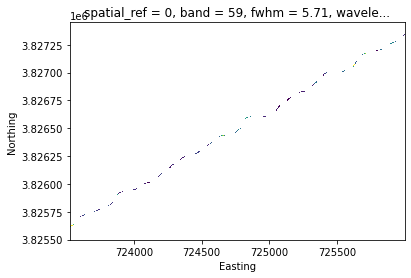

In [22]:
# Produces something weird...
clipped_red = clipped.sel(wavelength=670, method='nearest').Reflectance
clipped_red.plot.pcolormesh('Easting', 'Northing', robust=True, add_colorbar=False)

## Method 2. Using masking

Looking at the source code of `ds.rio.clip()`: Under the hood, it’s essentially doing two main things: 1) rasterize the provided geometry/shape vector into a boolean mask, and 2) apply the mask to the dataset with `ds.where(mask)`. We successfully attemptted to replicate this masking concept for this particular dataset. 

### A. Subset a box

Subset the simple box defined above by create masks that zero out pixels outside of the provided Easting and Northing range of values.

In [23]:
mask_easting = (ds.Easting >= box_minx) & (ds.Easting <= box_maxx)

In [24]:
mask_northing = (ds.Northing >= box_miny) & (ds.Northing <= box_maxy)

In [25]:
# Equivalent of &: np.logical_and()
cropped_ds = ds.where(mask_easting & mask_northing, drop=True) # Drop coordinate labels that only correspond to False values

In [26]:
 # Original ds dims: (x: 598. y: 16418, wavelength: 425)
cropped_ds

<xarray.Dataset>
Dimensions:      (x: 598, y: 743, wavelength: 425)
Coordinates:
    Easting      (x, y) float64 dask.array<chunksize=(100, 1), meta=np.ndarray>
    Northing     (x, y) float64 dask.array<chunksize=(100, 1), meta=np.ndarray>
    band         (wavelength) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    fwhm         (wavelength) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    spatial_ref  int64 0
  * wavelength   (wavelength) float64 377.1 382.1 387.1 ... 2.496e+03 2.501e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 594.5 595.5 596.5 597.5
  * y            (y) float64 1.3e+03 1.3e+03 1.302e+03 ... 2.04e+03 2.042e+03
Data variables:
    Elevation    (x, y) float64 dask.array<chunksize=(100, 1), meta=np.ndarray>
    Radiance     (x, y, wavelength) float32 dask.array<chunksize=(100, 1, 100), meta=np.ndarray>
    Reflectance  (x, y, wavelength) float32 dask.array<chunksize=(100, 1, 100), meta=np.ndarray>

This simple masking produces the correct box, with visible coastlines as quick sanity check.

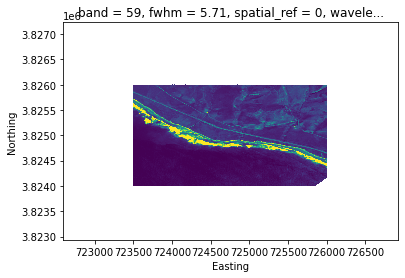

In [27]:
box_red = cropped_ds.sel(wavelength=670, method='nearest').Reflectance
box_red.plot.pcolormesh('Easting', 'Northing', robust=True, add_colorbar=False);

### B. Subset a more complex polygon

We expand the masking idea above to accomodate more arbitrary shapes. The approach: Given the approximate Easting and Northing coordinates that make up the vertices of the shape, for each coordinate, find the index of the grid point closest to that coordinate (by taking the min of the l-infinity norm). Then, use that index to get the xy dimension values. From this point on with vertices in xy values, rasterize this shape vector and mask the dataset.

Inspired by: https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/Nearest_lat-lon_Grid.ipynb

In [28]:
# Triangle
vertex_1 = (723500, 3824500)
vertex_2 = (724700, 3825500)
vertex_3 = (726000, 3824500)

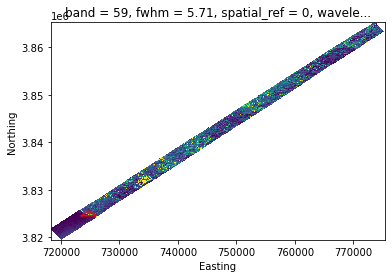

In [29]:
# Want this triangular region...
triangle_en_coords = Polygon([vertex_1, vertex_2, vertex_3])
triangle_pts = np.array(list(triangle_en_coords.exterior.coords))
Red.plot.pcolormesh('Easting', 'Northing', robust=True, add_colorbar=False)
plt.plot(triangle_pts[:,0], triangle_pts[:,1], c='r');

In [30]:
def find_nearest_point_xy(point):
    easting = point[0]
    northing = point[1]
    
    abs_easting = np.abs(ds.Easting.values - easting)
    abs_northing = np.abs(ds.Northing.values - northing)
    max_abs = np.maximum(abs_easting, abs_northing)
    xloc, yloc = np.where(max_abs == np.min(max_abs))
    
    xy_point = ds.isel(x=xloc[0], y=yloc[0])
    
    return xy_point.x.values, xy_point.y.values

In [31]:
x_1, y_1 = find_nearest_point_xy(vertex_1)
x_2, y_2 = find_nearest_point_xy(vertex_2)
x_3, y_3 = find_nearest_point_xy(vertex_3)

In [32]:
triangle = Polygon([(x_1, y_1), (x_2, y_2), (x_3, y_3)])

In [33]:
triangle_mask = rasterio.features.rasterize([triangle], out_shape=(ds.y.shape[0], ds.x.shape[0]))

In [34]:
triangle_mask = xr.DataArray(triangle_mask, dims=['y', 'x'])

In [35]:
subset_ds = ds.where(triangle_mask, drop=True)

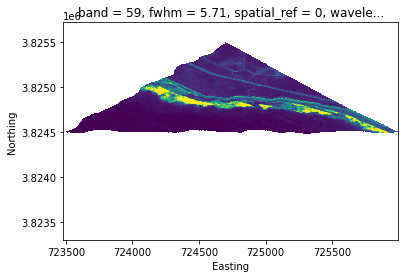

In [36]:
triangle_red = subset_ds.sel(wavelength=670, method='nearest').Reflectance
triangle_red.plot.pcolormesh('Easting', 'Northing', robust=True, add_colorbar=False);

#### Another arbitrary polygon

In [37]:
vertex_1 = (724500, 3826000)
vertex_2 = (726000, 3825000)
vertex_3 = (725500, 3823000)
vertex_4 = (724000, 3824000)
vertex_5 = (723500, 3825000)

In [38]:
x_1, y_1 = find_nearest_point_xy(vertex_1)
x_2, y_2 = find_nearest_point_xy(vertex_2)
x_3, y_3 = find_nearest_point_xy(vertex_3)
x_4, y_4 = find_nearest_point_xy(vertex_4)
x_5, y_5 = find_nearest_point_xy(vertex_5)

In [39]:
shape = Polygon([(x_1, y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4), (x_5, y_5)])

In [40]:
mask = rasterio.features.rasterize([shape], out_shape=(ds.y.shape[0], ds.x.shape[0]))

In [41]:
mask = xr.DataArray(mask, dims=['y', 'x'])

In [42]:
small_ds = ds.where(mask, drop=True)

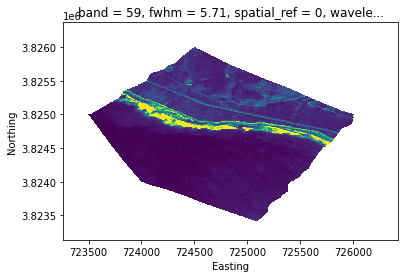

In [43]:
small_ds_red = small_ds.sel(wavelength=670, method='nearest').Reflectance
small_ds_red.plot.pcolormesh('Easting', 'Northing', robust=True, add_colorbar=False);

# Example analysis: Plotting DEM (digital elevation model) data and AVIRIS NDVI (Normalized Difference Vegetation Index) data

Subset to the same rectangular region (in Method 2A) in both data and plot the AVIRIS NVDI data as a function of the DEM elevation data.

### Compute AVIRIS NDVI

In [71]:
red = cropped_ds.sel(wavelength=670, method='nearest').Reflectance
nir = cropped_ds.sel(wavelength=820, method='nearest').Reflectance
ndvi = (nir - red) / (nir + red)

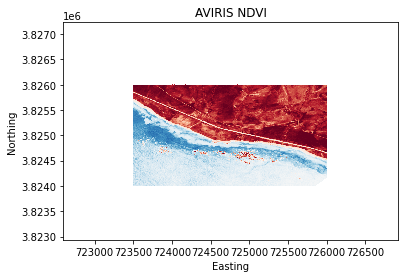

In [72]:
ndvi.plot.pcolormesh('Easting', 'Northing', robust=True, add_colorbar=False);
plt.title('AVIRIS NDVI');

### Read DEM data and subset to same region

In [73]:
# Read in DEM tif data
key_dem = 'raster-pregrid/DEM_30m_SRTM/'
s3_key_dem = os.path.join(bucket, key_dem)
item_dem = 'SRTM_1arc_SHIFT_box_UTM11N.tif'
s3_path_dem = f's3://{s3_key_dem}{item_dem}'

dem_tif = rxr.open_rasterio(s3_path_dem, masked=True)

In [74]:
# Reproject to AVIRIS CRS
dem_tif = dem_tif.rio.reproject('EPSG:32610')

In [75]:
# Check out the image bounds
dem_tif.rio.bounds()

(704855.037347487, 3760929.82905545, 833874.6046906871, 3882569.993104898)

In [76]:
# Crop DEM tif to the same box or rectangular region as AVIRIS
dem_tif_cropped = dem_tif.sel(x=slice(box_minx, box_maxx),
                              y=slice(box_maxy, box_miny))

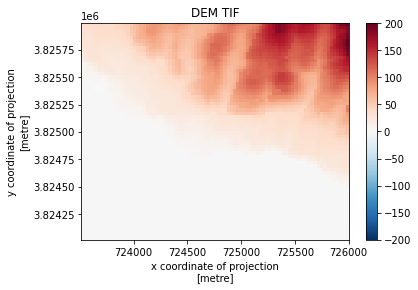

In [77]:
# Should see the same coastline as in AVIRIS NDVI plot
dem_tif_cropped.plot()
plt.title('DEM TIF');

### Plot NVDI vs DEM

In [78]:
# DEM and AVIRIS not same resolution - must be the same for scatterplot
dem_tif_cropped.shape, ndvi.shape

((1, 66, 83), (598, 743))

In [79]:
# Resize DEM array to shape of NDVI array using cv2 function
# Can also resize NDVI array to shape of DEM array
dem_tif_cropped = dem_tif_cropped.values[0]
ndvi = ndvi.values
dem_tif_resampled = cv2.resize(dem_tif_cropped, ndvi.shape[::-1], interpolation=cv2.INTER_NEAREST)

In [83]:
# They should now be the same shape
dem_tif_resampled.shape, ndvi.shape

((598, 743), (598, 743))

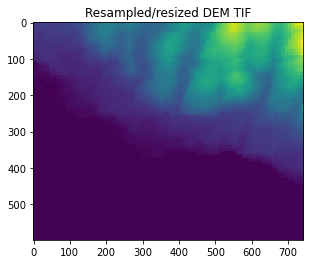

In [86]:
plt.imshow(dem_tif_resampled)
plt.title('Resampled/resized DEM TIF');

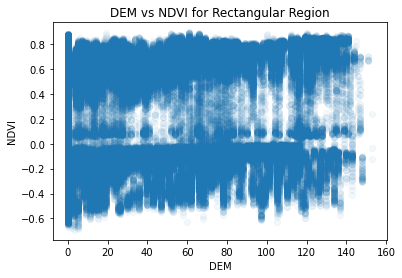

In [96]:
plt.scatter(dem_tif_resampled, ndvi, alpha=0.05)
plt.xlabel('DEM')
plt.ylabel('NDVI')
plt.title('DEM vs NDVI for Rectangular Region');